#### Cargar una de las imágenes histológicas

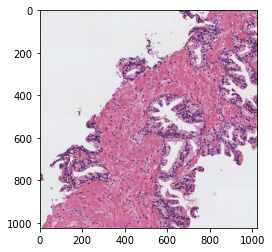

In [9]:
# Utiliza la librería skimage.io para leer la imagen 'histo_x.jpg' y visualízala usando la librería de matplotlib.
# Recuerda normalizar la imagen diviéndola entre 255

import matplotlib.pyplot as plt
import cv2
import numpy as np
import os
from skimage import io

img = io.imread('img/histo_1.jpg')
# img = io.imread('img/histo_2.jpg')

plt.imshow(img)
plt.show()

#### Realizar una transformación de color para convertir la imagen al espacio de color CMYK

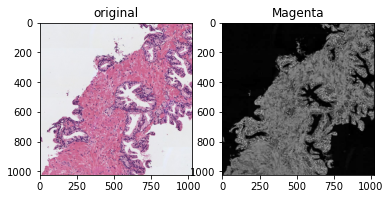

True

In [11]:
# 1) Extrae la componente magenta de la imagen (que corresponde a la región tisular)
# 2) Visualiza la imagen con la librería de matplotlib. 
# 3) Guarda la imagen Magenta con cv2.imwrite con el nombre "1_imagen_magenta.png"

img_rgb = cv2.imread('img/histo_1.jpg')
# img_rgb = cv2.imread('img/histo_2.jpg')
rgb = img_rgb.astype('uint8')/255

with np.errstate(invalid='ignore', divide='ignore'):
    K = 1 - np.max(rgb, axis=2)
    C = (1-rgb[...,2] - K)/(1-K)
    M = (1-rgb[...,1] - K)/(1-K)
    Y = (1-rgb[...,0] - K)/(1-K)

CMYK = (np.dstack((C,M,Y,K)))
C,M,Y,K = cv2.split(CMYK)
fig, ax = plt.subplots(1,2)

ax[0].imshow(img, cmap='gray'), ax[0].set_title('original')
ax[1].imshow(M, cmap='gray'), ax[1].set_title('Magenta')
plt.show()
cv2.imwrite('img' + os.sep + '1_imagen_magenta.png', M*255)

#### Umbralizar la imagen para separar los píxeles del fondo de la región tisular

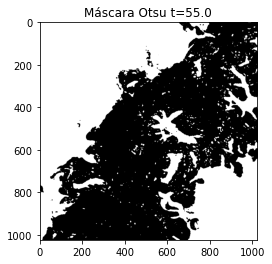

True

In [12]:
# 1) Convierte la imagen Magenta a formato "uint8"
# 2) Aplica un filtro gaussiano de tamaño 5x5
# 3) Umbraliza la imagen aplicando el método de Otsu
# 4) Aplica el umbral de manera que los píxeles del fondo y de los lúmenes sean 1s y el resto 0s. 
# 5) Visualiza la máscara resultante (imagen de 0s y 1s)
# 6) Guarda la máscara multiplicándola por 255 con el nombre "2_mascara_con_artefactos.png"

from skimage import img_as_ubyte

M = img_as_ubyte(M)
M_gauss = cv2.GaussianBlur(M, (5, 5), 0)
t, mask = cv2.threshold(M_gauss, 0, 1, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
mask = np.logical_not(mask).astype('uint8')

plt.imshow(mask, cmap='gray')
plt.title('Máscara Otsu t=' + str(t))
plt.show()
cv2.imwrite('img' + os.sep + '2_mascara_con_artefactos.png', mask*255)

#### Limpiar la imagen eliminando los artefactos de lumen (objetos blancos pequeños que no son lúmenes)

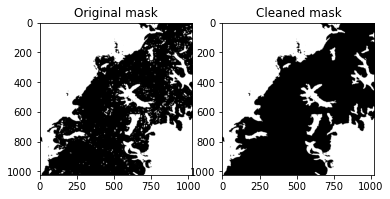

True

In [13]:
# 1) Utiliza la librería skimage.morphology.remove_small_objects. 
# Lee la documentación en https://scikit-image.org/docs/dev/api/skimage.morphology.html#skimage.morphology.remove_small_objects
# Fija el umbral en 300 píxeles y la conectividad del objeto en 8 píxeles.
# 2) Convierte la máscara generada en formato uint8
# 3) Visualiza la máscara resultante
# 4) Guarda la máscara multiplicándola por 255 con el nombre "3_mascara_sin_artefactos.png"

from skimage import morphology

arr = mask == 1
cleaned_mask = morphology.remove_small_objects(arr, min_size=300, connectivity=8)

cleaned_mask = cleaned_mask.astype('uint8')

fig, ax = plt.subplots(1,2)
ax[0].imshow(mask, cmap='gray'), ax[0].set_title('Original mask')
ax[1].imshow(cleaned_mask, cmap='gray'), ax[1].set_title('Cleaned mask')
plt.show()
cv2.imwrite('img' + os.sep + '3_mascara_sin_artefactos.png', cleaned_mask*255)

#### Rellenar con 0s el fondo de la imagen para quedarnos únicamente con los lúmenes

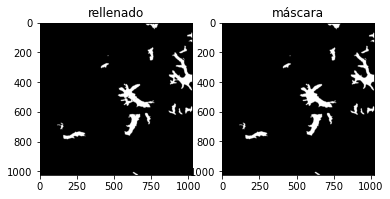

True

In [14]:
# 1) Aplica el algoritmo de expansión a partir de semillas para rellenar con 0s
# Pon dos semillas: una en la esquina superior izquierda y otra en la esquina inferior derecha.
# 2) Visualiza la máscara resultante
# 3) Guarda la máscara multiplicándola por 255 con el nombre "4_mascara_lumenes.png"

h, w = cleaned_mask.shape
mask_4 = np.zeros((h+2, w+2), np.uint8)
cv2.floodFill(cleaned_mask, mask_4, (0, 0), (0, 0, 0), cv2.FLOODFILL_FIXED_RANGE)
cv2.floodFill(cleaned_mask, mask_4, (1023, 1023), (0, 0, 0), cv2.FLOODFILL_FIXED_RANGE)
mask_4 = np.logical_not(mask_4).astype('uint8')

fig, ax = plt.subplots(1,2)
ax[0].imshow(cleaned_mask, cmap='gray'), ax[0].set_title('rellenado')
ax[1].imshow(mask_4, cmap='gray'), ax[1].set_title('máscara')
plt.show()
cv2.imwrite('img' + os.sep + '4_mascara_lumenes.png', mask_4*255)

#### Rellenar los objetos de los lúmenes

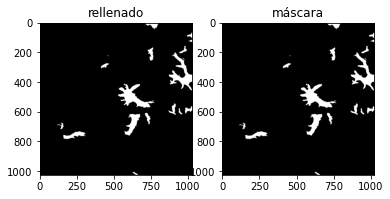

True

In [15]:
# 1) Rellena los lúmenes con la función binary_fill_holes de la librería scipy.ndimage.morphology
# 2) Convierte la máscara resultante en formato uint8
# 3) Visualiza la máscara
# 4) Guarda la máscara multiplicándola por 255 con el nombre "5_mascara_final.png"

from scipy import ndimage

mask_5 = ndimage.binary_fill_holes(mask_4)
mask_5 = mask_5.astype('uint8')

fig, ax = plt.subplots(1,2)
ax[0].imshow(mask_4, cmap='gray'), ax[0].set_title('rellenado')
ax[1].imshow(mask_5, cmap='gray'), ax[1].set_title('máscara')
plt.show()
cv2.imwrite('img' + os.sep + '5_mascara_final.png', mask_5*255)

#### Detectar y dibujar los contornos de los lúmenes sobre la imagen original

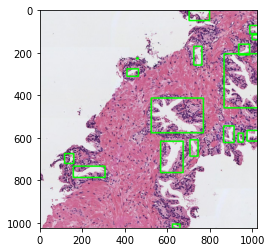

True

In [16]:
# 1) Encuentra los contornos de los lúmenes
# 2) Dibuja los contornos (de color verde) sobre la imagen original
# 3) Visualiza la imagen superpuesta
# 4) Guarda la imagen multiplicándola por 255 con el nombre "6_imagen_superpuesta.png"

from skimage.measure import label
from skimage.measure import regionprops
from skimage.morphology import convex_hull_image

lab, num = label(mask_5, return_num=True)
# print(f'numero de objetos: {num}')
v, c = np.unique(lab, return_counts=True)
# print(f'posibles valores de intensidad: {v}')

imagen = img.copy()
for i in range(1, num+1):
    objeto = lab == i
    objeto = objeto.astype('uint8')
    
    prop = regionprops(objeto)
    bbox = prop[0].bbox
    imagen = cv2.rectangle(imagen, (bbox[1], bbox[0]), (bbox[3], bbox[2]), (0, 255, 0), 5)

plt.imshow(imagen, cmap='gray')
plt.show()
cv2.imwrite('img' + os.sep + '6_imagen_superpuesta.png', imagen)

#### Identificar y cropear el lumen más grande

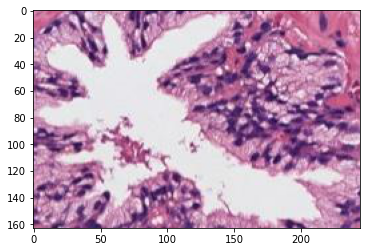

True

In [17]:
# 1) Convierte la máscara de lúmenes en una imagen de etiquetas utilizando la librería skimage.measure
# 2) Calcula el área de cada uno de los lúmenes 
# 3) Obtén una máscara del lumen de mayor área
# 4) Haz un crop (recorte) del lumen de mayor área utilizando las coordenadas de la bounding box
# 5) Visualiza la máscara recortada del lumen
# 6) Guarda la imagen multiplicándola por 255 con el nombre "7_crop_image.png"

new_lab, new_num = label(mask_5, return_num=True)

area = []
max_area = 0
max_area_index = 0

for i in range(1, new_num+1):
    objeto = new_lab == i
    prop = regionprops(objeto.astype(np.uint8))
    area.append(prop[0].area)
    if prop[0].area > max_area:
        max_area = prop[0].area
        max_area_image = objeto

new_objeto = max_area_image
prop = regionprops(new_objeto.astype(np.uint8))
bbox = prop[0].bbox
new_image = img[bbox[0]:bbox[2], bbox[1]:bbox[3]]
plt.imshow(new_image, cmap='gray')
plt.show()
cv2.imwrite('img' + os.sep + '7_crop_image.png', new_image)

#### Extraer 13 características geométricas que permitan caracterizar el lumen recortado 

In [18]:
# Calcula las siguientes características del crop del lumen anterior, redondeando su valor hasta el cuarto decimal.
# 1) Área
# 2) Área de la bounding box
# 3) Área convexa
# 4) Exentricidad
# 5) Diámetro equivalente
# 6) Extensión
# 7) Longitud del eje mayor
# 8) Longitud del eje menor
# 9) Orientación
# 10) Perímetro
# 11) Solidez
# 12) Compacidad
# 13) Rectangularidad

from tabulate import tabulate
import math

lab_final, num_final = label(max_area_image, return_num=True)

headers = ['', 'Lumen']
A, BB, CA, E, ED, EX, MA, MiA, P, S, CO, R = ['area'], ['bbox_area'], ['convex_area'], ['eccentricity'], ['equiv_diameter'], \
['extent'], ['major_axis'], ['minor_axis'], ['perimeter'], ['solidity'], ['compactness'], ['rectangularity']

objeto = lab_final == 1
prop = regionprops(objeto.astype(np.uint8))
A.append(np.round(prop[0].area, 4))
BB.append(np.round(prop[0].bbox_area, 4))
CA.append(np.round(prop[0].convex_area, 4))
E.append(np.round(prop[0].eccentricity, 4))
ED.append(np.round(prop[0].equivalent_diameter, 4))
EX.append(np.round(prop[0].extent, 4))
MA.append(np.round(prop[0].major_axis_length, 4))
MiA.append(np.round(prop[0].minor_axis_length, 4))
P.append(np.round(prop[0].perimeter, 4))
S.append(np.round(prop[0].solidity, 4))
CO.append(np.round(4*math.pi*prop[0].area/prop[0].perimeter**2, 4))
R.append(np.round(prop[0].area/prop[0].bbox_area, 4))

data = [tuple(A), tuple(BB), tuple(CA), tuple(E), tuple(ED), tuple(EX)\
        , tuple(MA), tuple(MiA), tuple(P), tuple(S), tuple(CO), tuple(R)]

print(tabulate(data, headers=headers))

                     Lumen
--------------  ----------
area            14064
bbox_area       39935
convex_area     29180
eccentricity        0.8471
equiv_diameter    133.816
extent              0.3522
major_axis        238.19
minor_axis        126.584
perimeter        1235.98
solidity            0.482
compactness         0.1157
rectangularity      0.3522
